# Deep Learning Project Walkthrough- Image Classification using CNN

---
***
<h3>Your Complete Guide on How to Make a Complete Deep Learning Project</h3>

Deep learning is a fancy word nowadays that you, as an aspiring Data Scientist might hear all the time. Whether it be the futuristic [Tesla Autopilot](http://www.tesla.com/autopilot) or your iOS or Android device's smart photo gallery that automatically segments your pictures using facial recognition and object detection, deep learning is everywhere. 

The sheer power that deep learning unlocks for you in terms of what you can achieve via it, that rapid advancements in the fields of AI due to deep learning; this never fails to amaze me.

The aim of this article here is to introduce you to the magic of Deep Learning. We will see how to train a Deep Learning model (that uses the CNN algorithm) capable of recognizing the scene in an image.

---
## Understanding the Problem Statement
---

For this project, we will be working on the [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification) dataset. 


This is a multi-class classification problem where, given a picture, we want our model to classify it as one of the six possible scenes - buildings (0), forest (1), glacier (2), mountain (3), sea (4) or street (5).

As per the data source, each image is a 150 × 150 pixel, 3-channeled (RGB) image, with around 14k images in the training set and 3k images in the testing set.

---
## Importing Project Dependencies
---

First, we will import all the necessary Python PyData modules. 

*One thing to be noted is that we are implementing the model using PyTorch.*

In [1]:
import os 
import torch  
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score 
from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

torch.manual_seed(5)
np.random.seed(5)

%matplotlib inline

---
## Preparing the Dataset
---
Now comes the first tricky part. If you look at the dataset directory, you will observe that we don't have any CSV file or a directly labelled data to work with. Rather, the training and testing data directories are further divided into subdirectories for each possible outcome class. So, in order to be able to work with this data, we need to restructure the data into a format that we can work on; a format that we are used to working with, basically CSV files and pandas.DataFrame objects. Also, since we will be implementing our Deep Learning model using PyTorch, we need to convert the images into tensor objects.

From a programmer's problem solving perspective, let us break down these problems-

1. 
    * Formatting the unstructured dataset into structured CSV and dataframe objects 
    * Adding label to the data
2. 
    * Converting the images into tensor objects 
    * Converting the dataframe into a PyTorch dataset
    
3. Creating a method to view the images from their tensor form 

### Creating the CSV files and dataframe objects-

In [2]:
train_img_parent = "../input/intel-image-classification/seg_train/seg_train" # train directory address
test_img_parent = "../input/intel-image-classification/seg_test/seg_test" # test directory address

classLabels = {'buildings':0, 'mountain':1, 'street':2, 'forest':3, 'sea':4, 'glacier':5}

In [3]:
def csv_maker(parent_dir, class_label, csv_name):
    """Converts unstructured data stored in subdirectories into dataframe and csv file
    
    Args-
        parent_dir- String containing address of parent directory(test data or training data)
        class_label- Class label dictionary object
        csv_name- Name you want to give to your returned csv file (string) 
        
    Returns-
        dataframe- A pandas.DataFrame object
    """
    labelled_arr = np.array([]) # creates an empty array
    
    for subdir, label in class_label.items():
        img_dir = os.path.join(parent_dir, subdir) # gets the path of each subdirectory in the parent data directory
        files = np.array(os.listdir(img_dir)).reshape(-1,1) # gets the list of names of each image
        labels = np.array([label for i in range(files.shape[0])]).reshape(-1,1) #creates a label column for the images
        data = np.concatenate((files, labels), axis = 1) # concatenates file name and label arrays into a single array
        labelled_arr = np.append(labelled_arr, data)
    
    labelled_arr = labelled_arr.reshape(-1,2)
    
    np.random.seed(5)
    np.random.shuffle(labelled_arr) # shuffles the dataset
    
    dataframe = pd.DataFrame(labelled_arr)
    dataframe.columns = ['image', 'label']
    dataframe['label'] = dataframe['label'].astype('int') 
    
    dataframe.to_csv(csv_name, index = False) # creates the csv file for the dataframe
    
    return dataframe

In [4]:
train_df = csv_maker(train_img_parent, classLabels, csv_name = "train.csv")

test_df = csv_maker(test_img_parent, classLabels, csv_name = "test.csv")

train_csv = "./train.csv"
test_csv = "./test.csv"

---

Let us now have a look at our training and testing datasets.

---

In [5]:
print("\nTraining DF-\n")
print(train_df.head())
print("\nTesting DF-\n")
print(test_df.head())


Training DF-

       image  label
0   6496.jpg      3
1   4571.jpg      0
2   5654.jpg      4
3  12656.jpg      4
4   5998.jpg      0

Testing DF-

       image  label
0  20372.jpg      5
1  21452.jpg      5
2  23016.jpg      5
3  21735.jpg      3
4  21919.jpg      3


---
Now that we have created the dataframe objects and CSV files for the testing and training dataset, let's create the PyTorch dataset objects that will allow us to use the image data with our PyTorch model. 

---

In [6]:
# creating custom pytorch dataset

class ImageDataset(Dataset):
    def __init__(self, dataframe, data_dir, label_dict, transform = None):
        self.df = dataframe
        self.data_dir = data_dir
        self.label_dict = label_dict
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name, label = self.df.loc[idx]
        class_labels = list(self.label_dict.keys())
        img_path = self.data_dir + '/' + class_labels[label] + '/' + img_name
        img = img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label        

Now, one of the transformations we will be performing on our images is normalizing them. Normalization is a key step in Deep Learning. By restraining the range in which the values are spread into a small range, you can really speed up the training speed. 

---
\***NOTE**- Since the process of calculation of the normalization parameters (mean and standard deviation can be really a CPU-resource-intensive task, I'll just run the code once then comment it out while storing the values to speed up the process next time we run the notebook.)

In [7]:
# R_sum = 0
# G_sum = 0
# B_sum = 0

# for i in range(len(train_dataset)):
#     R_sum += train_dataset[i][0][0].sum()
#     G_sum += train_dataset[i][0][1].sum()
#     B_sum += train_dataset[i][0][2].sum()

# R_mean = R_sum / (256*256*len(train_dataset))
# G_mean = G_sum / (256*256*len(train_dataset))
# B_mean = B_sum / (256*256*len(train_dataset))

In [8]:
# mean = (R_mean, G_mean, B_mean)
mean = (0.4302, 0.4575, 0.4539)

In [9]:
# R2_sum = 0
# G2_sum = 0
# B2_sum = 0

# for i in range(len(train_dataset)):
#     R2_sum += ((train_dataset[i][0][0] - mean[0])**2).sum()
#     G2_sum += ((train_dataset[i][0][1] - mean[1])**2).sum()
#     B2_sum += ((train_dataset[i][0][2] - mean[2])**2).sum()

# R_std = (R2_sum / (256*256*len(train_dataset)))**0.5
# G_std = (G2_sum / (256*256*len(train_dataset)))**0.5
# B_std = (B2_sum / (256*256*len(train_dataset)))**0.5

In [10]:
# std = (R_std, G_std, B_std)
std = (0.2606, 0.2588, 0.2907)

In [58]:
# We will try different transforms on our training data and compare the results. For now, let us stick to the training transforms given below

extra_transforms = (transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3, fill=0))


transformTrain1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(),
])

transformTrain2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply(extra_transforms, p=0.2),
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.2)),
])

# Transforms for test data
transformTest = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
])
    

In [59]:
# creating training dataset
train_dataset = ImageDataset(train_df, train_img_parent, classLabels, transform = transformTrain2)

# creating testing dataset
test_dataset = ImageDataset(test_df, test_img_parent, classLabels, transform = transformTest)

With this, we have successfully created both our training and testing datasets, and we are ready to work with them. 

But before we go on to the next step, let us first test our dataset and make sure it is working properly.

Total images in the dataset: 14034
tensor([[[0.3333, 0.3216, 0.3059, 0.2980, 0.2902],
         [0.3020, 0.3020, 0.3020, 0.3373, 0.3686],
         [0.2588, 0.2706, 0.2980, 0.3961, 0.4863],
         [0.2235, 0.2471, 0.2824, 0.3255, 0.3686],
         [0.1922, 0.2196, 0.2588, 0.2588, 0.2627]],

        [[0.4078, 0.4196, 0.4392, 0.4627, 0.4745],
         [0.3961, 0.4078, 0.4275, 0.4824, 0.5216],
         [0.3725, 0.3882, 0.4118, 0.5098, 0.5961],
         [0.3647, 0.3765, 0.3882, 0.4118, 0.4392],
         [0.3490, 0.3569, 0.3608, 0.3294, 0.3059]],

        [[0.0000, 0.0431, 0.1059, 0.2000, 0.2824],
         [0.0000, 0.0392, 0.1020, 0.2196, 0.3255],
         [0.0000, 0.0353, 0.0941, 0.2510, 0.3882],
         [0.0000, 0.0275, 0.0667, 0.1333, 0.1961],
         [0.0000, 0.0157, 0.0392, 0.0314, 0.0353]]])
Image label: forest


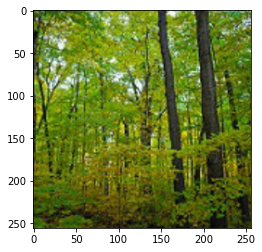

In [60]:
print("Total images in the dataset:", len(train_dataset))
img, label = train_dataset[0]
print(img[:,:5,:5]) # printing a small 3 x 5 x 5 slice of the 3 x 256 x 256 tensor
print("Image label:", list(classLabels.keys())[label])
plt.imshow(img.permute(1,2,0))


Now, the next challege. We need a method that allows us to feed data to our deep learning model for training as well as testing. Luckily, for this, we have the PyTorch's built-in DataLoader class. Let us create our dataloader objects.

### Defining Data Loaders

In [61]:
batch_size = 32
                                                                                
train_dl = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = 2, 
    pin_memory = True)

test_dl = DataLoader(
    dataset = test_dataset, 
    batch_size = batch_size, 
    shuffle = False, 
    num_workers = 2, 
    pin_memory = True)

One thing to be noted is that we set **shuffle = False** for test data loader as we aren't training the model on the test data. We are just using it to make predictions, for which there's no need to shuffle the data.

In [62]:
train_dl

Now that we have our dataloaders created, let us create a method to visualize the images in a batch.

In [63]:
def batch_viewer(dataloader):
    """Shows the images in a batch returned by the PyTorch dataloader object.
    
    Args-
        dataloader- PyTorch dataloader object
    
    Returns-
        None
    """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,16))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break    

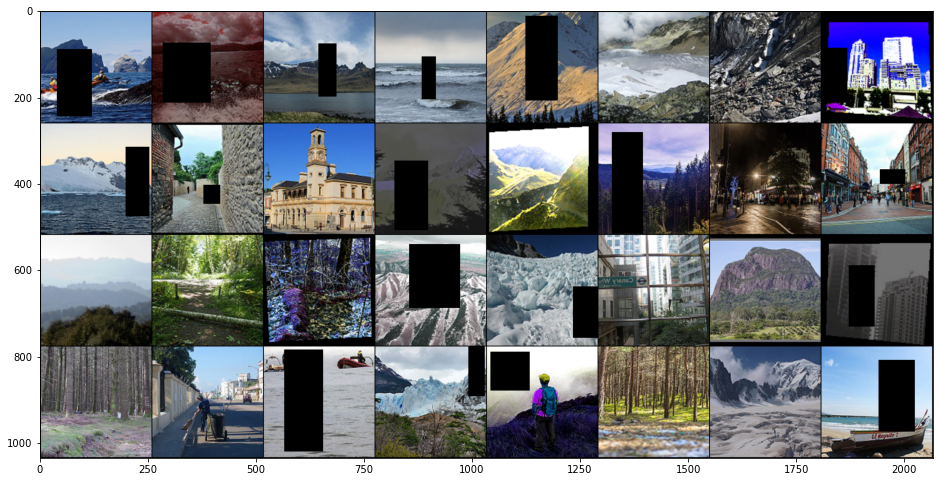

In [64]:
batch_viewer(train_dl)

---
## Model & Training
---

Now, let us move on to the next step. In this section, we will define our model class along with the loss function, scoring function and the various helper functions that will come handy while training and evaluating our model.

First, let us create a base class where we will define all the helper functions as well as our loss and accuracy functions. Then we will simply inherit the base class to another class where we will define our actual model.

This will allow us to keep our code clean and modular. Instead of redefining different model functions again and again from scratch, we can simply define a new model while our helper functions will remain the same.

In [ ]:
def accuracy(output, labels):
    """Calculates the accuracy for the predicted output and the actual label values.
    
    Agrs-
        output- Output tensor generated by the model
        labels- Actual labels for the given batch of data
    
    Returns-
        accuracy- Accuracy percentage for the predictions
    """
    softmax = nn.Softmax(dim=1)
    output = softmax(output) # converts output values to probability values for each class
    preds = torch.argmax(output, axis = 1) # sets class with max probability as prediction 
    accuracy = torch.sum(preds==labels).item() / len(labels) # accuracy = correct_prediction / total_predictions
    return torch.Tensor([accuracy])

class SceneClassificationBase(nn.Module):
    def training_step(self, batch):
        """Calculates the cross entropy loss for a given batch of data.
        
        Args-
            batch- One batch of data as generated by the data loader
        
        Returns-
            batch_loss- Total cross entropy loss for the batch
        """
        images, labels = batch 
        output = self(images)                  # generates predictions for the batch of images
        batch_loss = F.cross_entropy(output, labels) # calculates loss for the predictions and actual labels
        return batch_loss
    
    def validation_step(self, batch):
        """Calculates total validation loss and validation accuracy for a given batch data during a validation step.
        
        Args-
            batch- One batch of data as generated by the data loader
            
        Returns-
            A dictionary object containing validation loss and validation accuracy for the given batch
        """
        images, labels = batch 
        output = self(images)                    # generate predictions for given batch
        batch_loss = F.cross_entropy(output, labels)   # calculates batch loss
        batch_acc = accuracy(output, labels)           # calculate batch accuracy
        return {'val_loss': batch_loss.detach(), 'val_acc': batch_acc}
        
    def validation_epoch_end(self, outputs):
        """Calculates mean validation loss and mean validation accuracy for a one validation epoch.
        
        Args-
            outputs- A list of dictionary objects containing validation accuracy and validation loss for each batch of data in one epoch
            
        Returns-
            A dictionary object containing validation loss and validation accuracy for the given batch
        """
        batch_losses = [batch_val_dict['val_loss'] for batch_val_dict in outputs] # creates a list of batch losses for all the batches in one validation epoch
        epoch_loss = torch.stack(batch_losses).mean()   # calculates mean validation loss for the epoch
        batch_accs = [batch_val_dict['val_acc'] for batch_val_dict in outputs]   # creates a list of batch accuracies for all the batches in one validation epoch 
        epoch_acc = torch.stack(batch_accs).mean()      # calculates mean validation accuracy for the epoch
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, 
            result['lrs'][-1], 
            result['train_loss'], 
            result['val_loss'], 
            result['val_acc']))

In [ ]:
class Model_ResNet9(SceneClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(    # 3 x 256 x 256
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),    # 64 x 256 x 256
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
        )    
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),    # 128 x 256 x 256
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),    # 128 x 128 x 128 
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1), # 128 x 128 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1), # 128 x 128 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),    # 256 x 128 x 128
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),   # 256 x 64 x 64 
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),    # 512 x 64 x 64
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),    # 512 x 32 x 32 
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1), # 512 x 32 x 32
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1), # 512 x 32 x 32
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
        )
        self.classifier = nn.Sequential(nn.AvgPool2d(2, 2), # 512 x 16 x 16
                                        nn.Flatten(), 
                                        nn.Linear(512 * 16 * 16, 6),
        )
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.res1(output) + output
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.res2(output) + output
        output = self.classifier(output)
        return output
        

Now that we have defined our model, let us create a model object and test if everything is working properly.

In [ ]:
model = Model_ResNet9()
model

One of the advantages of working with Deep Learning frameworks like PyTorch is that they allow us to train our models on GPU. This can significantly speed up the training process as compared to training on CPUs, especially when we have huge datasets. [This](https://medium.com/@shachishah.ce/do-we-really-need-gpu-for-deep-learning-47042c02efe2#:~:text=The%20High%20bandwidth%2C%20hiding%20the,lot%20faster%20than%20a%20CPU.&text=CPU%20can%20train%20a%20deep,Learning%20Model%20efficiently%20and%20effectively.) article explains why GPUs are a better choice for Deep Learning as compared to CPUs.

Now, we need to define a method that allows us to push our model as well as the dataset onto the GPU during the training/testing process.

In [ ]:
def get_default_device():
    """Picks the trainig device-- GPU if available, else CPU.
    """
    if torch.cuda.is_available():   # checks if a cuda device is available
        return torch.device('cuda') # sets the default device as the available CUDA device
    else:
        return torch.device('cpu')  # if no CUDA device found, sets CPU as the default device
    
def to_device(data, device):
    """Move tensor(s) to chosen device
    """
    if isinstance(data, (list,tuple)): # asserts if the data is a list/tuple 
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to the default device.
    """
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device.
        """
        for batch in self.dl: 
            yield to_device(batch, self.device)

    def __len__(self):
        """Prints the total number of batches.
        """
        return len(self.dl)

With this done, we have successfully defined the method that allows batches of data generated by the dataloader to the CUDA device (our Nvidia GPU).

Now, let us check the default device we have available for the runtime.

In [ ]:
device = get_default_device()
device

As we can see, the default device is CUDA. This means our GPU is working just fine and we are ready to train/test the model. Now, let us move our device and dataloaders onto the default device. 

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

With the model and the dataloader moved to the GPU, we will now test the model on a batch of data to make sure everything is working fine before we actually move on to train/test on the entire training/testing dataset. This is like a precautionary step to make sure that we don't run into any major problem while the actual training/testing phase.

We will feed our model with a batch of data from the training dataloader. 

* The dimension of the input will be- batch_size x 3 x img_width x img_height
* The output dimension we expect is- batch_size x num_classes(6)

If everything works as expected, we will move on to the final step of our project-- training and evaluating our model.

In [ ]:
def try_batch(dataloader):
    for images, labels in dataloader:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

As we can see here, everything worked just fine. Let us now define the 'fit' function for our model. 

In [ ]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()    # sets the model to evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader] # performs validation for each batch and stores it in a list
    return model.validation_epoch_end(outputs) # returns mean validation accuracy and validation loss for one complete epoch

def get_lr(optimizer):
    """Gets the learning rate of the optimizer.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    
    torch.cuda.empty_cache()    # clears cache in CUDA device
    history = []    # declares an empty list to store result for each epoch
    
    # sets up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    
    # sets up one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_loader))
    
    for epoch in range(epochs): 
        model.train()    # initiate training phase
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):    # cycles through each batch of the training data
            loss = model.training_step(batch)    
            train_losses.append(loss)
            loss.backward()
            
            # perfomrs gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step() # updates parameters based on gradients obtained via optimizer.backwards()
            optimizer.zero_grad() # resets gradient values
            
            # records & updates learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()
        
        # initaites validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Now, let us have a look at the initial model accuracy and loss on the test dataset. One thing to be noted here is that we haven't done any training yet. So whatever the results will be are goinf to be based on entirely randomized model parameters. In order to improve the model's performance, we will need to optimize it, which will be done during the training phase.

In [ ]:
initial_acc_loss = evaluate(model, test_dl)
print(initial_acc_loss)

The initial model accuracy that we got is around 15%. Let us now train the model.

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

With this, we have completed the model training. It took around 37 minutes for the entire training process, and our model can now predict the scene in an image with upto 83% accuracy, which is considerably high. Of course, the model's performance can be further improved by playing around with the hypermeters or using with a different CNN architecture.

Let us now plot the model's accuracy and loss.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of Epochs')
    
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of Epochs')
    
plot_losses(history)

What's the point of making a scene classification model if we can't use it, right? So let us use our model and try to make predictions from it on individual images from the test set and see how our model is performing.

In [ ]:
def predict_single_image(image_data):
    image, label = image_data
    label = list(classLabels.keys())[label]
    # displaying the image
    plt.imshow(image.permute(1,2,0))
    print("Actual label: ", label)
    # using model to predict image label
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    prediction = list(classLabels.keys())[torch.argmax(prediction).item()]
    print("Prediction: ", prediction)

In [ ]:
predict_single_image(test_dataset[69])

The model made a correct prediction. This was a pretty easy problem from a human point of view. One can clearly see this image is showing a huge water body.

In [ ]:
predict_single_image(test_dataset[420])

The model made a wrong prediction on this image. And to be honest, this one is quite complex for even a human eye. One can see mountains in the image, so it can be classified as a 'mountain' scene. The white region below the mountains looks like waves. So it can be classified as a 'sea', which is exactly what our model did. But unfortunately, the white region is the frozen ice of a glacier.

In [ ]:
predict_single_image(test_dataset[100])

This was an easy classification. An as we can see, our model did a good job on this one.

Let us now save our model in case we would like to use it in the future for making classifications.

In [ ]:
torch.save(model.state_dict(), 'sceneClassification_ResNet9.pth')

With this, we come to an end of one part of our project where we used a ResNet9 CNN model to train and test a multi-class scene classification model.